In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
img_dir = '/kaggle/input/satalite/data/images'
lbl_dir = '/kaggle/input/satalite/data/labels'

# Data Loading and Preprocessing

In [9]:
import os
import numpy as np
import rasterio
from PIL import Image
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(img_dir, lbl_dir):
    images = []
    labels = []
    for image_name in os.listdir(img_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(img_dir, image_name)
            try:
                with rasterio.open(image_path) as src:
                    img = src.read()
                    img = np.transpose(img, (1, 2, 0))  #(height, width, channels)
                
                # Normalize
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                # taking the mean over the channels to make sure it has 1 channel 
                img = np.mean(img,axis=2, keepdims=True)
                img = np.resize(img,(128,128,1))
                
                # Load corresponding label
                lbl_name = image_name.replace('.tif', '.png')
                lbl_path = os.path.join(lbl_dir, lbl_name)
                lbl = np.array(Image.open(lbl_path))
                lbl = lbl / 255.0
                
                images.append(img)
                labels.append(lbl)
            except Exception as e:
                print(f"Error processing file {image_name}: {e}")
    
    return np.array(images), np.array(labels)


# Call the load_preprocess function
X, y = load_and_preprocess_images(img_dir, lbl_dir)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Data shapes:
X_train: (244, 128, 128, 1)
y_train: (244, 128, 128)
X_val: (62, 128, 128, 1)
y_val: (62, 128, 128)


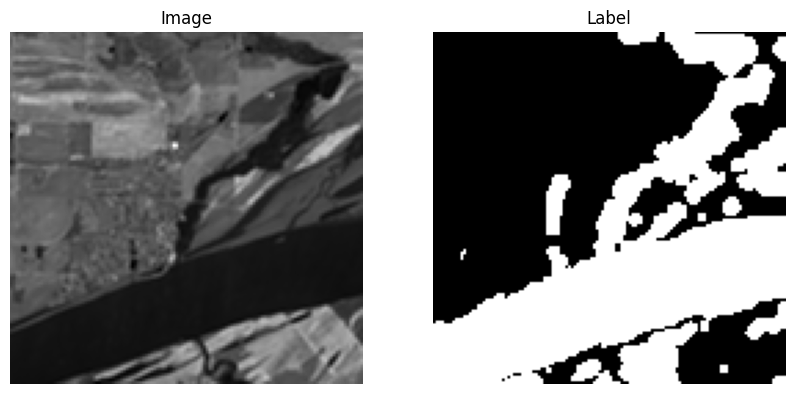

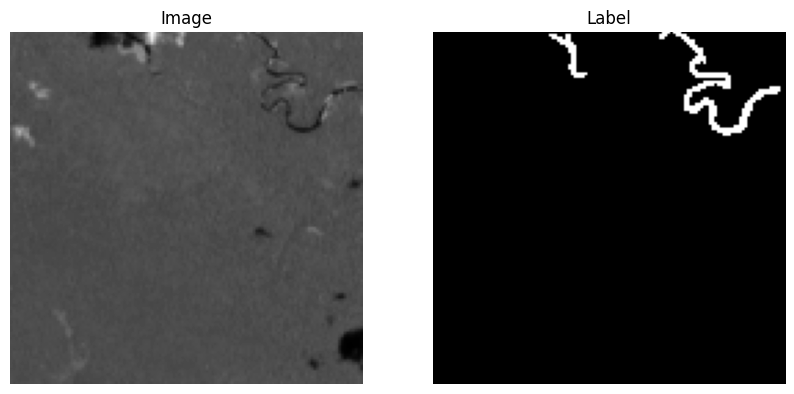

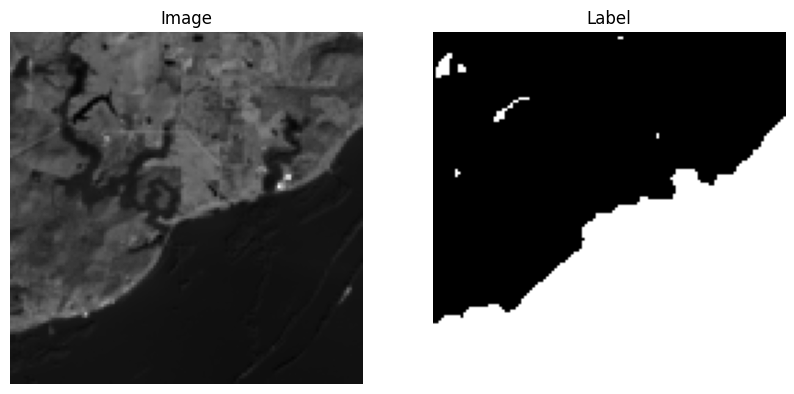

In [36]:
import matplotlib.pyplot as plt

def visualization(X,y,num_samp=3):
    for index in range(num_samp):
        img = X[index].squeeze()
        label =y[index]

        fig,ax = plt.subplots(1,2,figsize=(10,5))

        ax[0].imshow(img,cmap='gray')
        ax[0].set_title('Image')
        ax[0].axis('off')


        ax[1].imshow(label,cmap='gray')
        ax[1].set_title('Label')
        ax[1].axis('off')

        plt.show()
    
    
visualization(X_train,y_train,num_samp=3)

In [ ]:
# from tensorflow.keras import backend as K

# def dice_coefficient(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coefficient_loss(y_true, y_pred):
#     return 1 - dice_coefficient(y_true, y_pred)


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',  
    save_best_only=True,
    mode='max',  
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=10,  
    mode='max',  
    verbose=1,
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5,  
    patience=5,  
    min_lr=1e-6, 
    verbose=1
)


callbacks_list = [checkpoint, early_stopping, reduce_lr]

# Build the UNet Model Archicture

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Encoder (Downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder (Upsampling)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model(input_size=(128, 128, 1))
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_60[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_62[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_64[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_66[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 32, 32,    │          0 │ conv2d_67[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 32, 32,    │          0 │ up_sampling2d_12… │
│ (Concatenate)       │ 768)              │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_12[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_68[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (None, 64, 64,    │          0 │ conv2d_69[0][0] 

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=['accuracy'])
# model.compile(optimizer='adam', loss=dice_coefficient_loss, metrics=[dice_coefficient])

In [40]:
history = model.fit(X_train, y_train, 
                    batch_size=16, 
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[callbacks_list],
                    verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7324 - loss: 0.6390 
Epoch 1: val_accuracy improved from -inf to 0.75478, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 189s 12s/step - accuracy: 0.7326 - loss: 0.6318 - val_accuracy: 0.7548 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7050 - loss: 0.0180 
Epoch 2: val_accuracy did not improve from 0.75478
16/16 ━━━━━━━━━━━━━━━━━━━━ 183s 11s/step - accuracy: 0.7068 - loss: 0.0179 - val_accuracy: 0.7548 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7485 - loss: 0.0159 
Epoch 3: val_accuracy did not improve from 0.75478
16/16 ━━━━━━━━━━━━━━━━━━━━ 182s 11s/step - accuracy: 0.7478 - loss: 0.0159 - val_accuracy: 0.7548 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7519 - loss: 0.0157 
Epoch 4: val_accuracy did not imp

In [15]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.0202
Validation Accuracy: 0.7548


# Using Pretrained Model MobileNet

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Lambda
import tensorflow as tf

def unet_model_mobilenet(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # replicate the input size channel by 3 to match the pretrained model input size (128,128,3)
    input_3_channel = Lambda(lambda x: tf.repeat(x, 3, axis=-1),
                                output_shape=(input_size[0], input_size[1], 3))(inputs)
    
    # load the pretrained model's weights
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # some selected layers from the mobilenet pretrained model which will be used in the skip connection
    encoder_outputs = [
        base_model.get_layer('block_1_expand_relu').output,    # 64x64x96
        base_model.get_layer('block_3_expand_relu').output,    # 32x32x144
        base_model.get_layer('block_6_expand_relu').output,    # 16x16x192
        base_model.get_layer('block_13_expand_relu').output,   # 8x8x576
    ]
    
    # encoder model
    encoder = Model(inputs=base_model.input, outputs=encoder_outputs)
    
    # Apply the encoder to our input
    x = input_3_channel
    # output feature map from the encoder
    encoder_features = encoder(x)
    
    
    # Bridge
    
    # only the last feature map was taken as an input the the conv layer
    bridge = Conv2D(512, 3, activation='relu', padding='same')(encoder_features[-1])
    bridge = Conv2D(512, 3, activation='relu', padding='same')(bridge)
    
    
    #decoder
    
    x = bridge
    # the last feature map encoder is excluded beacuse it's already taken in the bridge layer
    for i, encoder_feature in enumerate(reversed(encoder_features[:-1])):
        # convtrans to upsample and reconstruct the img, scale the img by dividing by the power 2 of the index which will reduce the number of filters i each iteration
        x = Conv2DTranspose(256 // (2**i), 3, strides=2, padding='same')(x)
        x = concatenate([x, encoder_feature])
        x = Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)
        x = Conv2D(256 // (2**i), 3, activation='relu', padding='same')(x)
    
    # additional upsampling to restore the original spatial dimention of the original img 
    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    
    
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
pretrained_model = unet_model_mobilenet(input_size=(128, 128, 1))
pretrained_model.summary()

pretrained_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ [(None, 64, 64,   │    616,256 │ lambda_1[0][0]    │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 8, 8, 512) │  2,654,720 │ functional_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_86[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │  1,179,904 │ conv2d_87[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ functional_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 16, 16,    │  1,032,448 │ concatenate_18[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_88[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 32, 32,    │    295,040 │ conv2d_89[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ functional_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 32, 32,    │    313,472 │ concatenate_19[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_90[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 64, 64,    │     73,792 │ conv2d_91[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 160)              │            │ functional_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 64, 64,    │     92,224 │ concatenate_20[0… │
│                     │ 64)               │            │                 

 Total params: 9,429,249 (35.97 MB)

 Trainable params: 9,411,969 (35.90 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [43]:
history = pretrained_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks_list
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6307 - loss: 0.5103
Epoch 1: val_accuracy did not improve from 0.75478
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.6343 - loss: 0.5005 - val_accuracy: 0.7548 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7553 - loss: 0.0176
Epoch 2: val_accuracy did not improve from 0.75478
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.7542 - loss: 0.0176 - val_accuracy: 0.7548 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7413 - loss: 0.0163
Epoch 3: val_accuracy did not improve from 0.75478
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.7410 - loss: 0.0164 - val_accuracy: 0.7548 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7372 - loss: 0.0166
Epoch 4: val_accuracy did not improve from 0.75478
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 

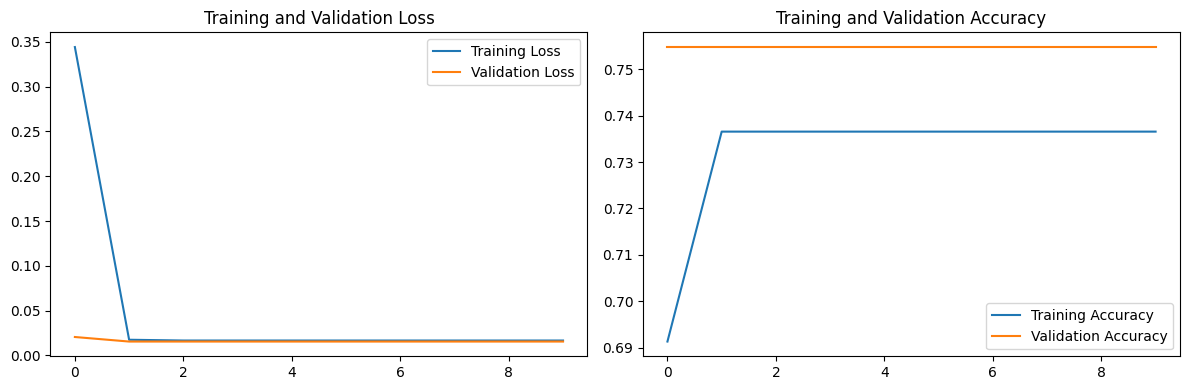

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()